In [1]:
import statistics
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, vstack
import astropy.units as u


plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 24,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

In [ ]:
with fits.open('http://www.gama-survey.org/dr4/data/cat/gkvInputCat/v02/gkvInputCatv02.fits') as cat:
    gkvInputCat = Table(cat[1].data)

with fits.open('http://www.gama-survey.org/dr4/data/cat/StellarMasses/v24/StellarMassesGKVv24.fits') as cat:
    StellarMassesGKV = Table(cat[1].data)

In [9]:
#import GAMA
with fits.open('/data2/lsajkov/mpdg/data/GAMA/GAMA_mstars_concat.fits') as hdu:
    GAMA_mstar_concat = Table(hdu[1].data)

In [10]:
#produce magnitude columns
GAMA_fluxJy_r = GAMA_mstar_concat['flux_rt'] * u.Jansky
GAMA_fluxerrJy_r = GAMA_mstar_concat['flux_err_rt']

GAMA_fluxJy_g = GAMA_mstar_concat['flux_gt'] * u.Jansky
GAMA_fluxerrJy_g = GAMA_mstar_concat['flux_err_gt']

GAMA_mag_r = GAMA_fluxJy_r.to(u.ABmag).value
GAMA_magerr_r = errJy_to_errABmag(GAMA_fluxJy_r, GAMA_fluxerrJy_r).value

GAMA_mag_g = GAMA_fluxJy_g.to(u.ABmag).value
GAMA_magerr_g = errJy_to_errABmag(GAMA_fluxJy_g, GAMA_fluxerrJy_g).value

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [11]:
#"circularize" the elliptical aperture used to do photometry:
#assume "axial ratio" is defined as ratio = semiminor axis/semimajor axis
GAMA_axial_ratios = GAMA_mstar_concat['axrat']
GAMA_half_light_radii = GAMA_mstar_concat['R50']

#ratio (e) = semiminor (a)/semimajor (b)
#area of elliptical aperture = area of idealized circular aperture
#pi*a*b = pi*r^2
#a*b = r^2
#b^2/e = r^2
#r = b/sqrt(e)

GAMA_ideal_half_light_radii = GAMA_half_light_radii/np.sqrt(GAMA_axial_ratios)

#following derivation, we find Rfwhm = 1.75 R50
GAMA_approx_fwhm = 1.75 * GAMA_ideal_half_light_radii

In [12]:
#produce additional columns

#g-r color columns
GAMA_gr_color = GAMA_mstar_concat['absmag_g'] - GAMA_mstar_concat['absmag_r']
GAMA_gr_color_err =  np.hypot(GAMA_magerr_g, GAMA_magerr_r)

#effective surface brightness column
GAMA_mu_r_eff = GAMA_mag_r + 2.5 * np.log10(2 * np.pi * GAMA_approx_fwhm ** 2)

/var/tmp/lsajkov/ipykernel_709844/1216344638.py:8: RuntimeWarning: overflow encountered in square
  GAMA_mu_r_eff = GAMA_mag_r + 2.5 * np.log10(2 * np.pi * GAMA_approx_fwhm ** 2)


In [13]:
#vectorize
GAMA_vect_data = Table([GAMA_mstar_concat['uberID_1'],
                        GAMA_mag_r, GAMA_magerr_r,
                        GAMA_mu_r_eff,
                        GAMA_gr_color, GAMA_gr_color_err,
                        GAMA_mstar_concat['logmstar'],
                        GAMA_mstar_concat['Z'],
                        GAMA_mstar_concat['snratio']],
                        names = ['ID',
                                 'r_mag', 'r_mag_err',
                                 'surf_bright_r',
                                 'gr_color', 'gr_color_err',
                                 'log_stellar_mass',
                                 'redshift',
                                 'snr'
                        ])

In [15]:
#define primary targeting region
def gr_color_condition(gr_color, gr_color_err,
               r_mag):
    
    return (gr_color - gr_color_err + 0.06 * (r_mag - 14)) < 0.9


def surf_bright_condition(surf_bright_r, surf_bright_r_err,
                                 r_mag):
    
    return (surf_bright_r + surf_bright_r_err\
            - 0.7 * (r_mag - 14)) > 18.5

In [21]:
#produce primary targeting region
gr_color_mask    = gr_color_condition(GAMA_vect_data['gr_color'],
                                      GAMA_vect_data['gr_color_err'],
                                      GAMA_vect_data['r_mag'])

surf_bright_mask = surf_bright_condition(GAMA_vect_data['surf_bright_r'],
                                         GAMA_vect_data['r_mag_err'],
                                         GAMA_vect_data['r_mag'])

r_mag_mask = (GAMA_vect_data['r_mag'] > 18)

in_prim_targ_reg = gr_color_mask & surf_bright_mask & r_mag_mask
in_prim_targ_reg_plot = gr_color_mask & surf_bright_mask

print(f'In the primary targeting region, there are {np.sum(in_prim_targ_reg)}/{len(in_prim_targ_reg)} objects.')

In the primary targeting region, there are 139291/370116 objects.


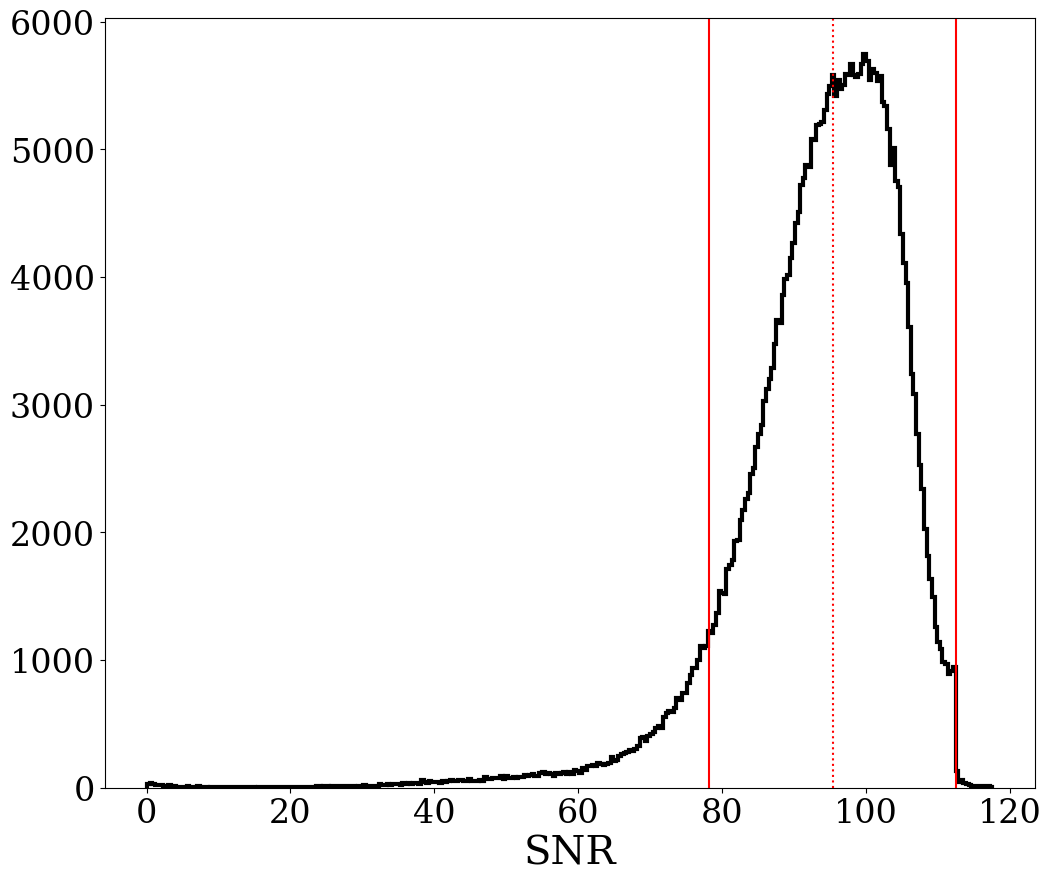

In [17]:
fig = plt.figure(figsize = (12, 10))
ax  = fig.add_subplot()

snr_vals = GAMA_vect_data['snr']
snr_median = np.nanmedian(snr_vals)
snr_sigma = np.std(snr_vals)

histvals = ax.hist(snr_vals, bins = 'auto', histtype = 'step',
                   linewidth = 3, color = 'black')

ax.set_xlabel('SNR')

ax.axvline(snr_median - 1.5 * snr_sigma, color = 'red')
ax.axvline(snr_median + 1.5 * snr_sigma, color = 'red')

ax.axvline(snr_median, color = 'red', linestyle = ':')

In [18]:
#quality cut (conservative to save on computation time)
log_mstar_thresh_lo = 6
log_mstar_thresh_hi = 12
snr_thresh = 100

quality_cut = (GAMA_vect_data['log_stellar_mass'] < log_mstar_thresh_hi) &\
              (GAMA_vect_data['log_stellar_mass'] > log_mstar_thresh_lo) &\
              (GAMA_vect_data['snr'] > snr_thresh)
            #   (GAMA_vect_data['gr_color'] < 1)

print(f'With this cut, {np.sum(quality_cut)}/{len(quality_cut)} objects are kept')

With this cut, 99385/370116 objects are kept


In [22]:
total_cut = quality_cut & in_prim_targ_reg

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_709844/450098763.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$g_{\mathrm{abs}}-r_{\mathrm{abs}}$')
/var/tmp/lsajkov/ipykernel_709844/450098763.py:27: SyntaxWarning: invalid escape sequence '\o'
  fig.colorbar(mappable = hb, label = 'Median log$(M_*/M_{\odot})$')


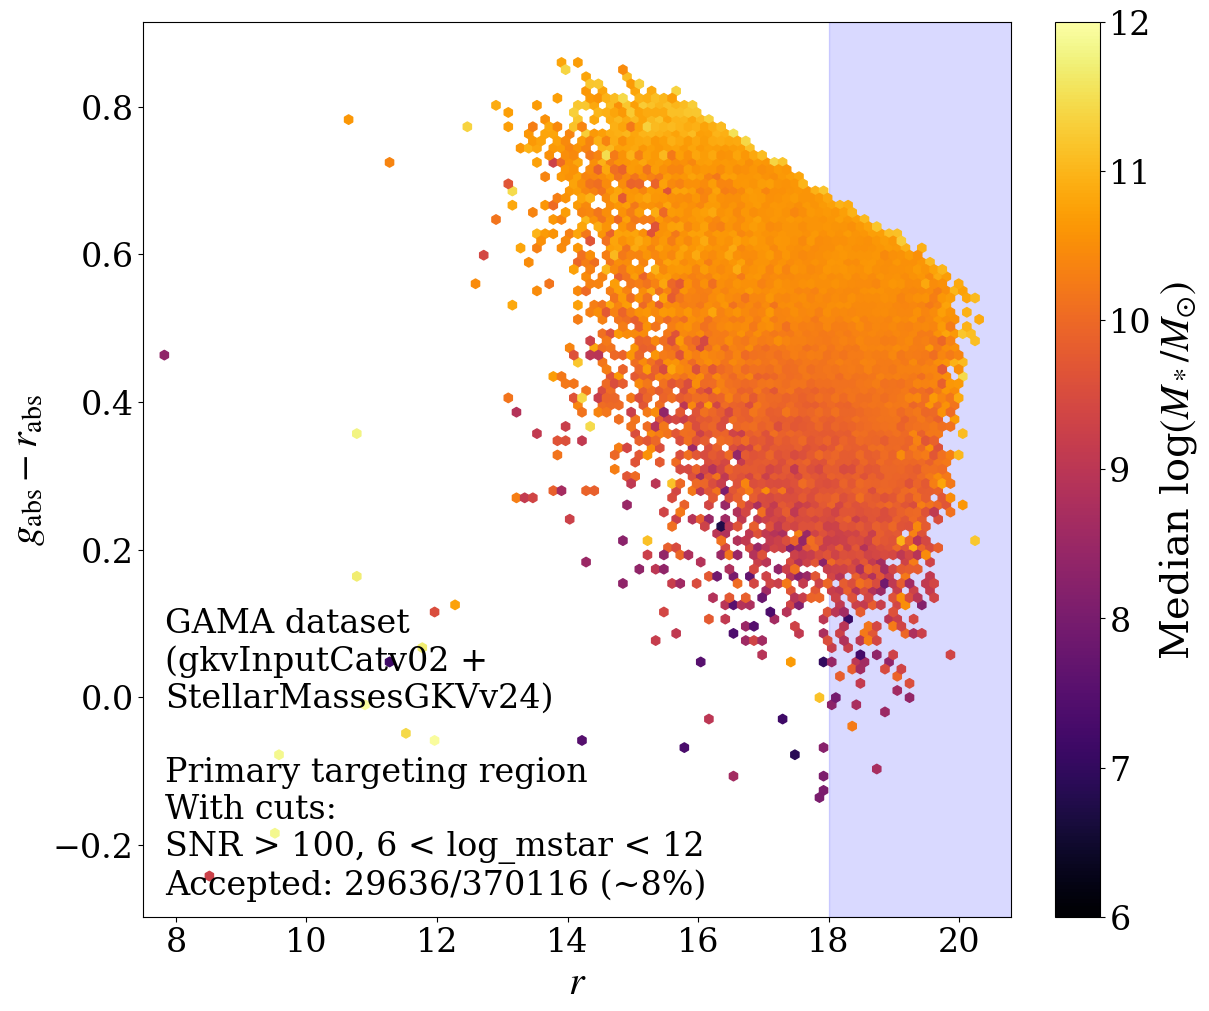

In [31]:
fig = plt.figure(figsize = (12, 10), constrained_layout = True)
ax  = fig.add_subplot()

plot_idx = quality_cut & in_prim_targ_reg_plot

hb  = ax.hexbin(GAMA_vect_data[plot_idx]['r_mag'],
               GAMA_vect_data[plot_idx]['gr_color'],
               C = GAMA_vect_data[plot_idx]['log_stellar_mass'],
               reduce_C_function = np.median,
               cmap = 'inferno',
               vmin = 6, vmax = 12)

plot_text = 'GAMA dataset\n(gkvInputCatv02 +\nStellarMassesGKVv24)\n\n' +\
            'Primary targeting region\n' +\
           f'With cuts:\nSNR > {snr_thresh}, {log_mstar_thresh_lo} < log_mstar < {log_mstar_thresh_hi}\n' +\
           f'Accepted: {np.sum(total_cut)}/{len(total_cut)} (~{int(100 * np.sum(total_cut)/len(total_cut))}%)'

ax.text(0.025, 0.025, plot_text, transform = ax.transAxes)

ax.set_xlabel('$r$')
ax.set_ylabel('$g_{\mathrm{abs}}-r_{\mathrm{abs}}$')

ax.axvspan(18, 21, color = 'blue', alpha = 0.15, zorder = 0)

ax.set_xlim(7.5, 20.8)

fig.colorbar(mappable = hb, label = 'Median log$(M_*/M_{\odot})$')

fig.savefig('/data2/lsajkov/mpdg/figures/primary_targeting_region/GAMA_primary_targ_reg_gr_col_03jul2024.png',
            dpi = 150, bbox_inches = 'tight')

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_709844/3948274853.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mu_{r, \mathrm{eff}}$')
/var/tmp/lsajkov/ipykernel_709844/3948274853.py:27: SyntaxWarning: invalid escape sequence '\o'
  fig.colorbar(mappable = hb, label = 'Median log$(M_*/M_{\odot})$')


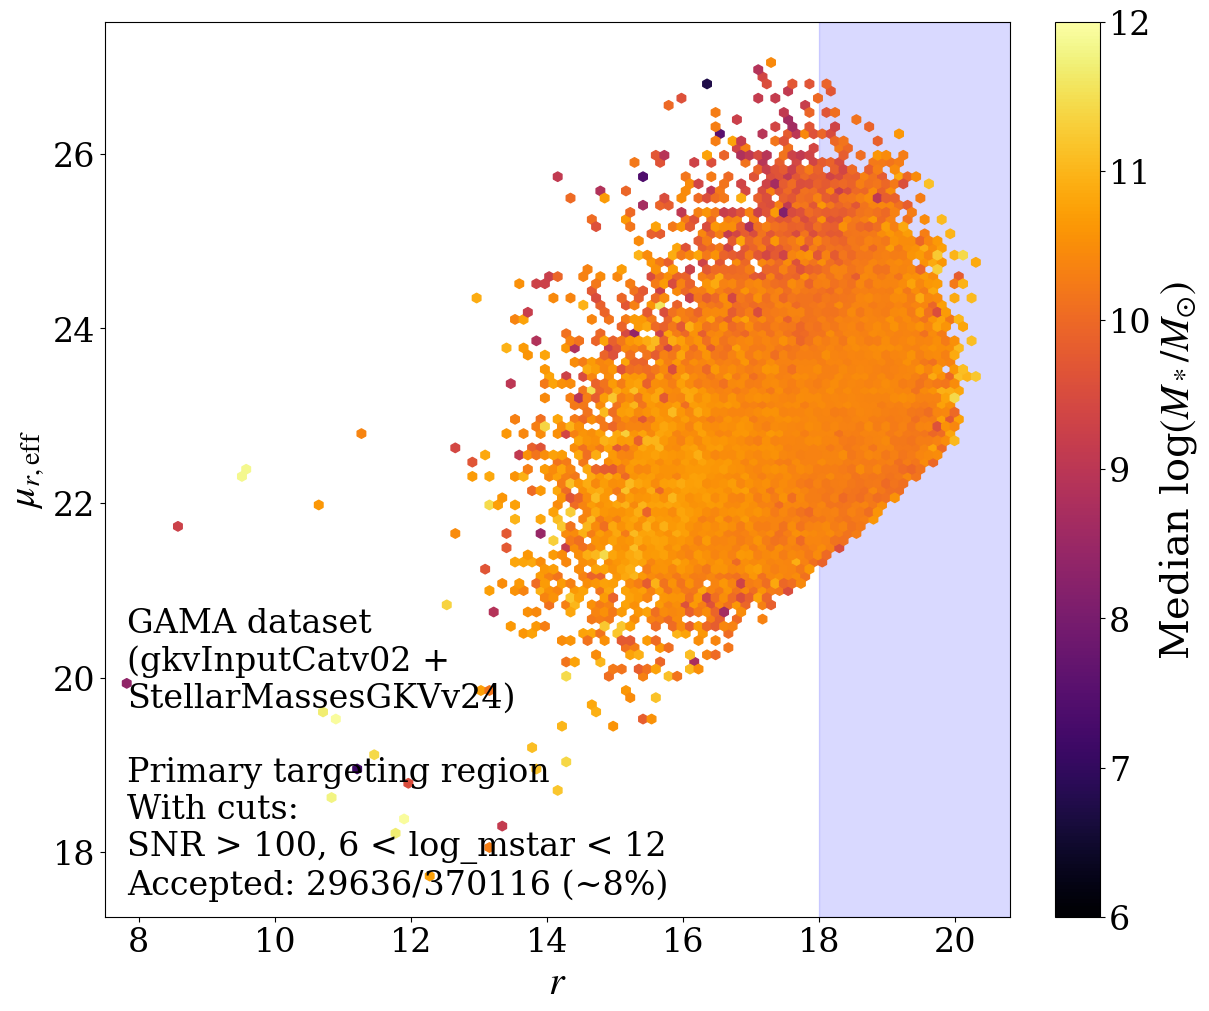

In [30]:
fig = plt.figure(figsize = (12, 10), constrained_layout = True)
ax  = fig.add_subplot()

plot_idx = quality_cut & in_prim_targ_reg_plot

hb  = ax.hexbin(GAMA_vect_data[plot_idx]['r_mag'],
               GAMA_vect_data[plot_idx]['surf_bright_r'],
               C = GAMA_vect_data[plot_idx]['log_stellar_mass'],
               reduce_C_function = np.median,
               cmap = 'inferno',
               vmin = 6, vmax = 12)

plot_text = 'GAMA dataset\n(gkvInputCatv02 +\nStellarMassesGKVv24)\n\n' +\
            'Primary targeting region\n' +\
           f'With cuts:\nSNR > {snr_thresh}, {log_mstar_thresh_lo} < log_mstar < {log_mstar_thresh_hi}\n' +\
           f'Accepted: {np.sum(total_cut)}/{len(total_cut)} (~{int(100 * np.sum(total_cut)/len(total_cut))}%)'

ax.text(0.025, 0.025, plot_text, transform = ax.transAxes)

ax.set_xlabel('$r$')
ax.set_ylabel('$\mu_{r, \mathrm{eff}}$')

ax.axvspan(18, 21, color = 'blue', alpha = 0.15, zorder = 0)

ax.set_xlim(7.5, 20.8)

fig.colorbar(mappable = hb, label = 'Median log$(M_*/M_{\odot})$')

fig.savefig('/data2/lsajkov/mpdg/figures/primary_targeting_region/GAMA_primary_targ_reg_mu_eff_03jul2024.png',
            dpi = 150, bbox_inches = 'tight')

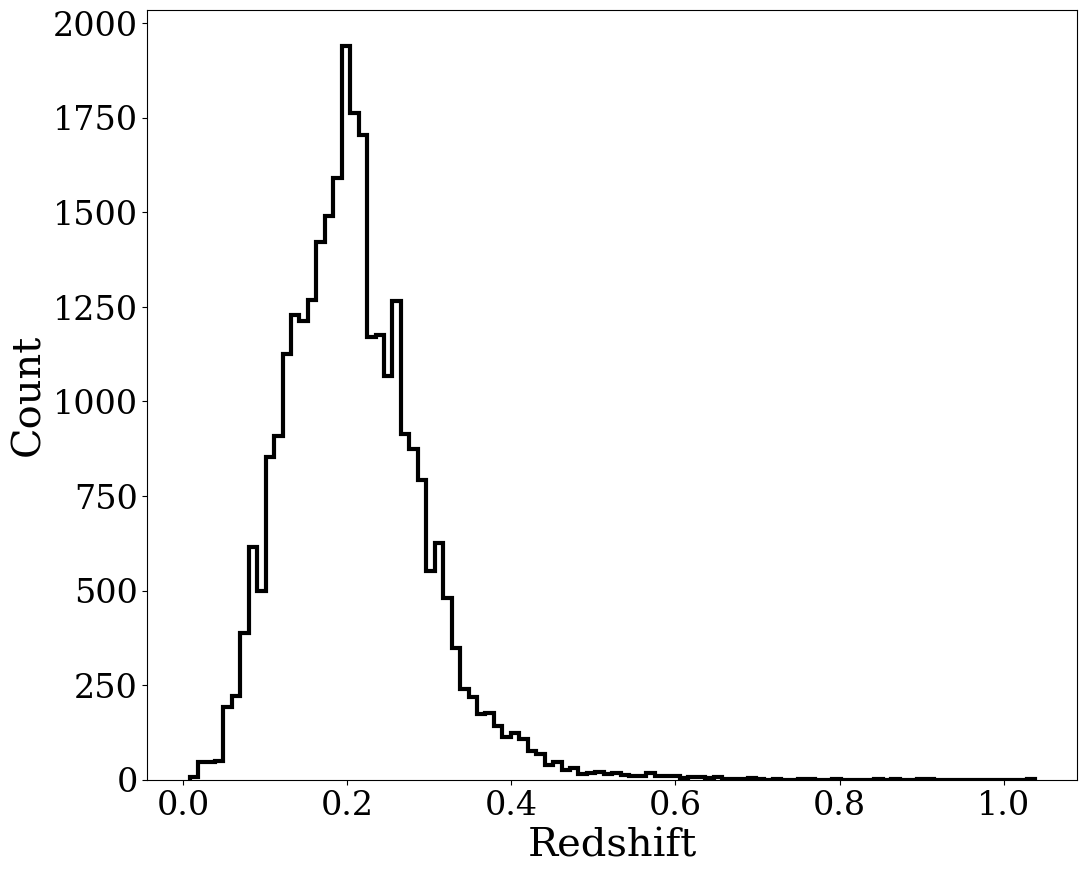

In [46]:
fig = plt.figure(figsize = (12, 10))
ax  = fig.add_subplot()

ax.hist(GAMA_vect_data[total_cut]['redshift'],
        bins = 100, histtype = 'step',
        color = 'black', linewidth = 3)

ax.set_xlabel('Redshift')
ax.set_ylabel('Count')

fig.savefig('/data2/lsajkov/mpdg/figures/primary_targeting_region/GAMA_ptr_redshift_03jul2024.png',
            dpi = 150, bbox_inches = 'tight')

<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_709844/3233884006.py:8: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('log$(M_*/M_{\odot})$')


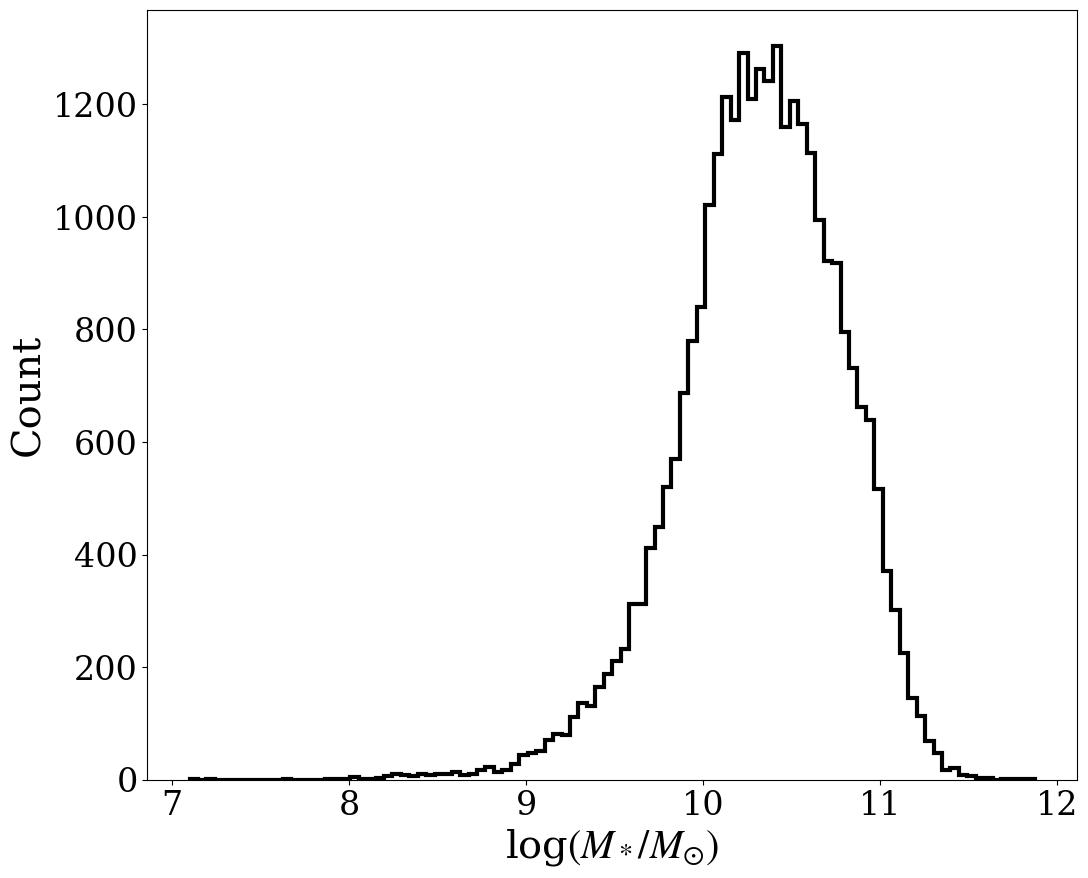

In [45]:
fig = plt.figure(figsize = (12, 10))
ax  = fig.add_subplot()

ax.hist(GAMA_vect_data[total_cut]['log_stellar_mass'],
        bins = 100, histtype = 'step',
        color = 'black', linewidth = 3)

ax.set_xlabel('log$(M_*/M_{\odot})$')
ax.set_ylabel('Count')

fig.savefig('/data2/lsajkov/mpdg/figures/primary_targeting_region/GAMA_ptr_logmstar_03jul2024.png',
            dpi = 150, bbox_inches = 'tight')

In [33]:
GAMA_vect_data[total_cut].write('/data2/lsajkov/mpdg/data_products/GAMA/GAMA_primtarg_snr100_lms6_12_03jul2024.fits',
                                overwrite = True)